# IMPORTS

In [377]:
import pandas as pd
import random
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for cramer v
from scipy import stats as ss
#for univariate analysis
from pandas_profiling import ProfileReport
#preprocessing
from sklearn.preprocessing import FunctionTransformer, PowerTransformer,\
MaxAbsScaler, StandardScaler, RobustScaler, MinMaxScaler
# for under/over sampling
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from imblearn import combine as c
#for ML analysis
from sklearn import metrics as m
from scikitplot import metrics as mt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
from tensorflow.keras import models as ml
from tensorflow.keras import layers as l
from tensorflow.keras.callbacks import EarlyStopping

## Data

In [2]:
SEED=42

In [3]:
data = pd.read_csv('../PS_20174392719_1491204439457_log.csv')

In [4]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
data[['step','isFraud']].groupby('isFraud').count()

,step
isFraud,
0,6354407
1,8213


In [6]:
# # para usar tudo
# df1=data.copy()

In [7]:
# para usar apenas parte dos dados
df1=data[data['type'].apply(lambda x: x in ['CASH_OUT', 'TRANSFER'])] #selecionar apenas cash out e transfer
df1=df1.groupby('isFraud').apply(lambda x: x.sample(frac=0.1))
df1=df1.reset_index(drop=True)

In [8]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', True )
    
    sns.set()

In [9]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Helper functions

In [439]:
def cross_validation( target, data2crossv, kfold, model_name, model, verbose=False ):
    acc_list = []
    balanced_acc_list = []
    f1_list = []
    kappa_list = []
    
    kfold = ms.StratifiedKFold( n_splits=kfold, shuffle=True, random_state=SEED )
#     tscv = TimeSeriesSplit(n_splits=kfold)
    
    #data2crossv.set_index(['date'])
    X=data2crossv.drop(target,axis=1)
    Y=data2crossv[target]
    
    for train_index,test_index in kfold.split(X,Y):
        
        #splitting
        xtraining, xvalidation, ytraining, yvalidation = X.values[train_index], X.values[test_index], \
                                       Y.values[train_index], Y.values[test_index]

        # model and prediction
        if model_name=='Neural Net':
            early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
            model.fit( xtraining, ytraining, epochs=20, validation_data=(x_test, y_test), verbose=1, callbacks=[early_stop])
            yhat = model.predict_classes(xvalidation)
        else:
            m = model.fit( xtraining, ytraining.ravel() )
            yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, yvalidation, yhat)

        # store performance of each kfold iteration
        acc_list.append(  m_result['Accuracy'] )
        balanced_acc_list.append( m_result['Balanced accuracy'] )
        f1_list.append( m_result['F1 score'] )
        kappa_list.append( m_result['Kappa Metrics'] )
        
    return pd.DataFrame( {'Model Name': model_name,
                          'ACC CV': np.round( np.mean( acc_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( acc_list ), 3 ).astype( str ),
                          'Balanced ACC CV': np.round( np.mean( balanced_acc_list ), 3).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list ), 3 ).astype( str ),
                          'F1 CV': np.round( np.mean( f1_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( f1_list ), 3 ).astype( str ),
                          'Kappa CV': np.round( np.mean( kappa_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_list ), 3 ).astype( str )
                         }, index=[0] )

In [298]:
def ml_error( model_name, y, yhat ):
    # Accuracy
    acc = m.accuracy_score( y, yhat )
    # Balanced Accuracy
    balanced_acc = m.balanced_accuracy_score( y, yhat )
    # F1 score
    f1 = m.f1_score( y, yhat )
    # Kappa Metrics
    kappa = m.cohen_kappa_score( y, yhat )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'Accuracy': acc,
                           'Balanced accuracy': balanced_acc,
                           'F1 score': f1, 
                           'Kappa Metrics': kappa
                         }, index=[0] )

In [13]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [14]:
def mod_round(x):
    x=abs(x)
    x=round(x)
    return x

In [15]:
# make list of variables types
def variable_types(data):
    # numerical: discrete and continuous
    discrete = [var for var in data.columns if data[var].dtype != 'O' and data[var].nunique() < 35]
    continuous = [var for var in data.columns if data[var].dtype != 'O' and var != 'survived' and var not in discrete]

    # categorical
    categorical = [var for var in data.columns if data[var].dtype == 'O']

    print('There are {} discrete variables'.format(len(discrete)))
    print('There are {} continuous variables'.format(len(continuous)))
    print('There are {} categorical variables'.format(len(categorical)))
    
    return discrete,continuous,categorical

# FEATURE ENGINEERING

In [16]:
df2=df1.copy()

## Cash Flow feature

In [17]:
# cash flow
df2['FlowOrig']=df2['newbalanceOrig']-df2['oldbalanceOrg']
df2['FlowDest']=df2['newbalanceDest']-df2['oldbalanceDest']

## Amount is different than cash flow flag feature

In [18]:
# flag if amount is different than cash flow
df2['amount_anomaly_orig']=(df2['FlowOrig']).apply(mod_round)!=df2['amount'].apply(mod_round)
df2['amount_anomaly_dest']=(df2['FlowDest']).apply(mod_round)!=df2['amount'].apply(mod_round)

## Inflow vs Outflow

In [19]:
df2['FluxOrig']=df2['FlowOrig'].apply(sign)
df2['FluxDest']=df2['FlowDest'].apply(sign)

## Anomaly flow

In [20]:
df2['disc_orig_amount']=abs(df2['newbalanceOrig']-df2['oldbalanceOrg'])-df2['amount']
df2['disc_dest_amount']=abs(df2['newbalanceDest']-df2['oldbalanceDest'])-df2['amount']

## Name Char feature

In [21]:
# name origin engineering mixed type variable
df2['nameOrig_char']=df2['nameOrig'].str[0] # captures the first letter
df2['nameOrig_num']=df2['nameOrig'].str.extract('(\d+)') # captures numerical part

In [22]:
# name destination engineering mixed type variable
df2['nameDest_char']=df2['nameDest'].str[0] # captures the first letter
df2['nameDest_num']=df2['nameDest'].str.extract('(\d+)') # captures numerical part

In [23]:
# nameOrig_char contains no information
df2['nameOrig_char'].unique()

array(['C'], dtype=object)

In [24]:
df2['nameDest_char'].unique()

array(['C'], dtype=object)

In [25]:
# if first char is M thare is actually no anomaly
df2.loc[df2['nameDest_char']=='M',['amount_anomaly_dest']]=False

## Drop

'nameOrig','nameDest','nameOrig_char'

In [26]:
#drop redundant columns
df2.drop(labels=['nameOrig','nameDest','nameOrig_char'],axis=1,inplace=True)

## Criando colunas de número de transações

In [27]:
count_map = df2['nameDest_num'].value_counts().to_dict()
df2['num_of_transactions_dest']=df2['nameDest_num'].map(count_map)
# df2.sample(2)

In [28]:
count_map = df2['nameOrig_num'].value_counts().to_dict()
df2['num_of_transactions_orig']=df2['nameOrig_num'].map(count_map)
# df2.sample(2)

## Drop

In [29]:
# Deletar colunas de numero de conta
df2.drop(['nameOrig_num','nameDest_num'],axis=1,inplace=True)

## Criação de features day e hour

In [30]:
df2['day'] = df2.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)

In [31]:
df2['hour']=df2['day']*24-df2['step']

## Criando feature flux

In [32]:
#Essa variavel deveria mostrar se o fluxo esta certo (-1 significa entrando de uma fonte e saindo da outra)
df2['Flux']=df2['FluxOrig']*df2['FluxDest']

# FEATURE SELECTION

In [33]:
df3=df2.copy()

In [34]:
df3.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud',
       'FlowOrig', 'FlowDest', 'amount_anomaly_orig', 'amount_anomaly_dest',
       'FluxOrig', 'FluxDest', 'disc_orig_amount', 'disc_dest_amount',
       'nameDest_char', 'num_of_transactions_dest', 'num_of_transactions_orig',
       'day', 'hour', 'Flux'],
      dtype='object')

In [35]:
# #manual selection
# df4=df3.drop(['step','amount','isFlaggedFraud','Flux','newbalanceOrig',\
#          'newbalanceDest','nameDest_char'],axis=1)

In [37]:
#manual selection
df3=df3.drop(['step','isFlaggedFraud','FlowOrig','FlowDest',\
         'nameDest_char','Flux'],axis=1)

# DATA BALANCE

**Analysis**
* near-miss 1,2 and 3 removes outliers from class no-fraud and can balance 1:1
* OneSidedSelection is more theoritically consistent but can balance only around 10:1
* NeighbourhoodCleaningRule and tomeklinks is bad at balancing
* Maybe combining algorithims that can't balance 1:1 with random undersamper?
* Better test every undersampler with gridsearch pipeline

# DATA PREPARATION

In [122]:
df4=df3.copy()

## Categorical variables

In [123]:
discrete,continuous,categorical=variable_types(df4)

There are 9 discrete variables
There are 7 continuous variables
There are 1 categorical variables


In [125]:
df4[categorical] = pd.get_dummies(df4[categorical],drop_first=True)

In [251]:
df4[categorical].sample(3)

,type
138380,0
72786,0
27096,0


## Undersampling

In [130]:
X=df4.drop(['isFraud'],axis=1)
y=df4['isFraud']

In [131]:
undersample = OneSidedSelection(sampling_strategy='majority', n_neighbors=1, n_seeds_S=5000, random_state=SEED)
X_tl, y_tl = undersample.fit_sample(X, y)
df4us=pd.concat([X_tl,y_tl],axis=1)

## Outlier capping

In [191]:
df4ol=df4us.copy()

In [179]:
df4us.columns

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'amount_anomaly_orig', 'amount_anomaly_dest',
       'FluxOrig', 'FluxDest', 'disc_orig_amount', 'disc_dest_amount',
       'num_of_transactions_dest', 'num_of_transactions_orig', 'day', 'hour',
       'isFraud'],
      dtype='object')

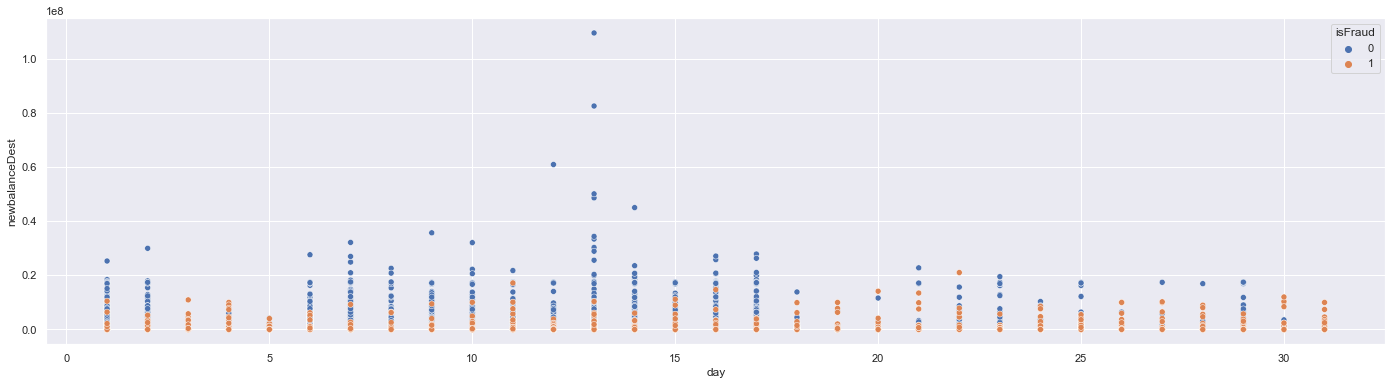

0    276128
1       821
Name: isFraud, dtype: int64

In [190]:
plt.figure(figsize=(24,6))
sns.scatterplot(x='day', y='newbalanceDest', hue='isFraud', data=df4us)
# plt.ylabel(var)
# plt.title('step x ' + var)
plt.show()
aux.isFraud.value_counts()

In [192]:
amount_ol=1.5e7
oldbalancedest_ol=3e7
newbalancedest_ol=3e7
df4ol.loc[df4ol['amount']>amount_ol,['amount']]=amount_ol
df4ol.loc[df4ol['oldbalanceDest']>oldbalancedest_ol,['oldbalanceDest']]=oldbalancedest_ol
df4ol.loc[df4ol['newbalanceDest']>newbalancedest_ol,['newbalanceDest']]=newbalancedest_ol

In [193]:
df4ol['flag_outlier']=(df4ol['amount']>1.5e7) | (df4ol['oldbalanceDest']>3e7) | (df4ol['newbalanceDest']>3e7)

## Continuous variables

### log-scaling

In [205]:
df5=df4ol.copy()

In [206]:
discrete,continuous,categorical=variable_types(df5)

There are 10 discrete variables
There are 7 continuous variables
There are 0 categorical variables


#### data preparation for log scaling

In [207]:
#multiplicar disc_orig_amount por -1
df5['disc_orig_amount']=-df5['disc_orig_amount']

In [208]:
for var in continuous:
    c=df5[var].min()
    if c<=1:
        df5[var]=df5[var]+abs(1-c)

In [209]:
df5[continuous].min()

amount              1.0
oldbalanceOrg       1.0
newbalanceOrig      1.0
oldbalanceDest      1.0
newbalanceDest      1.0
disc_orig_amount    1.0
disc_dest_amount    1.0
dtype: float64

#### transformation

In [210]:
aux=df5.copy()
cols=continuous
# transformer = PowerTransformer(method='box-cox', standardize=False)
transformer = FunctionTransformer(np.log, validate=True)
transformer.fit(aux[cols].fillna(1))
data_t = transformer.transform(aux[cols].fillna(1))
data_t = pd.DataFrame(data_t, columns = cols)
# for var in cols:
#     diagnostic_plots(data_t, var)

In [214]:
cont_data=data_t.copy()
aux=data_t.copy()
aux=pd.concat([aux,df5[['day','isFraud']]],axis=1)

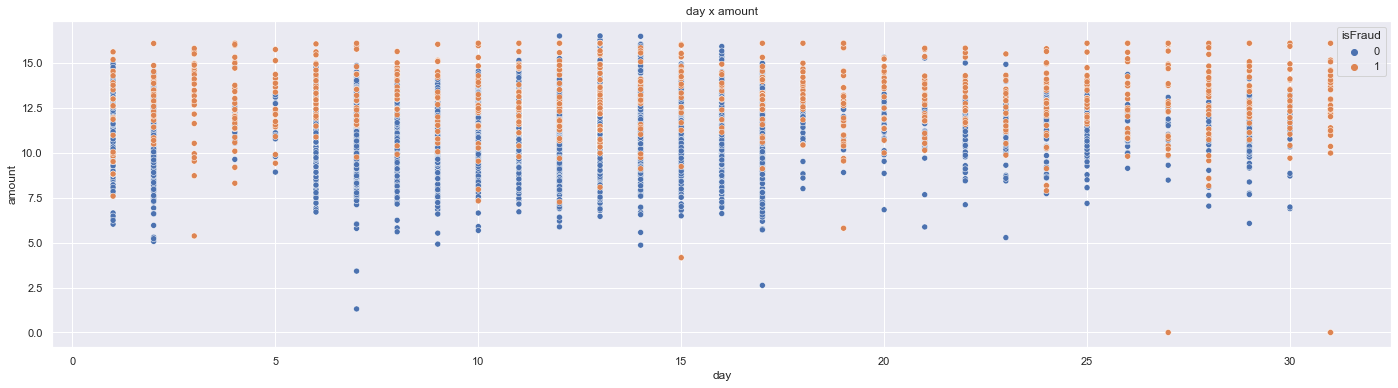

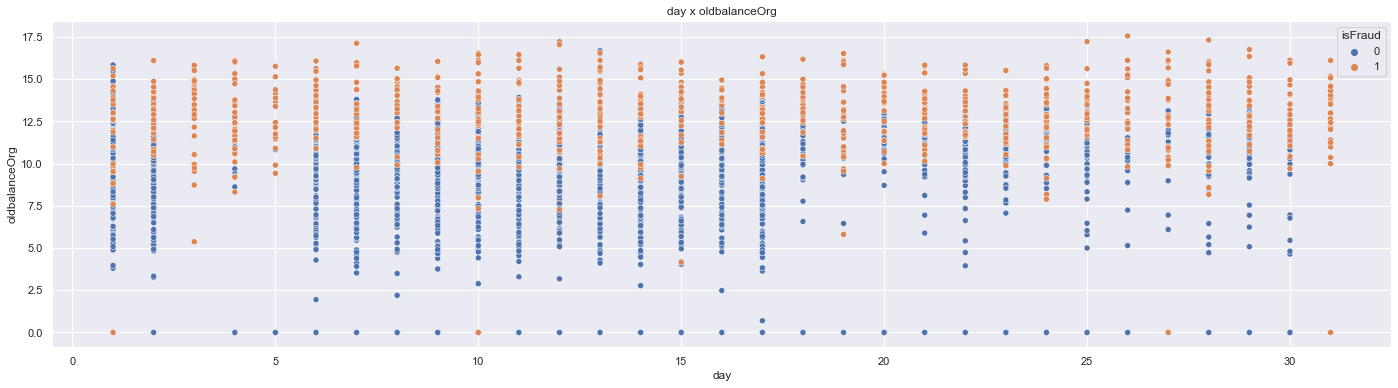

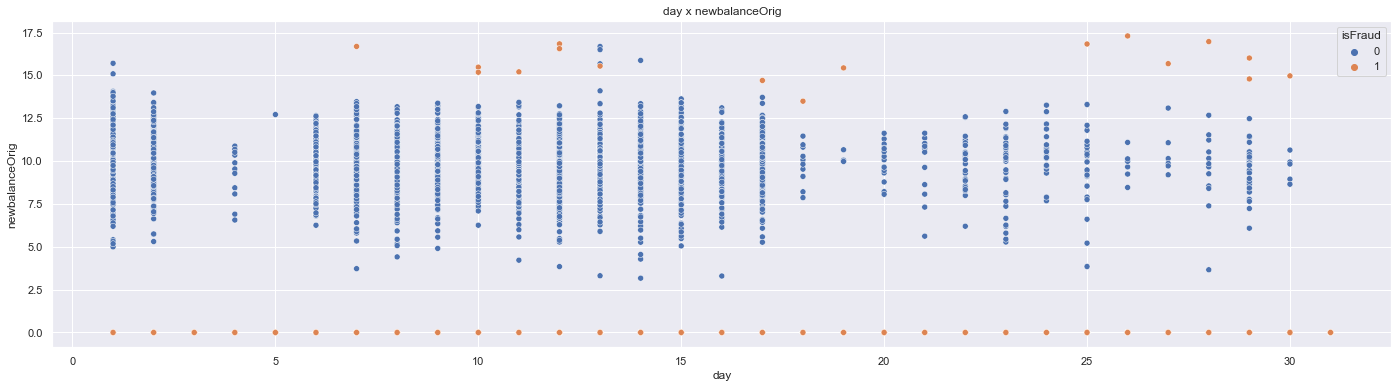

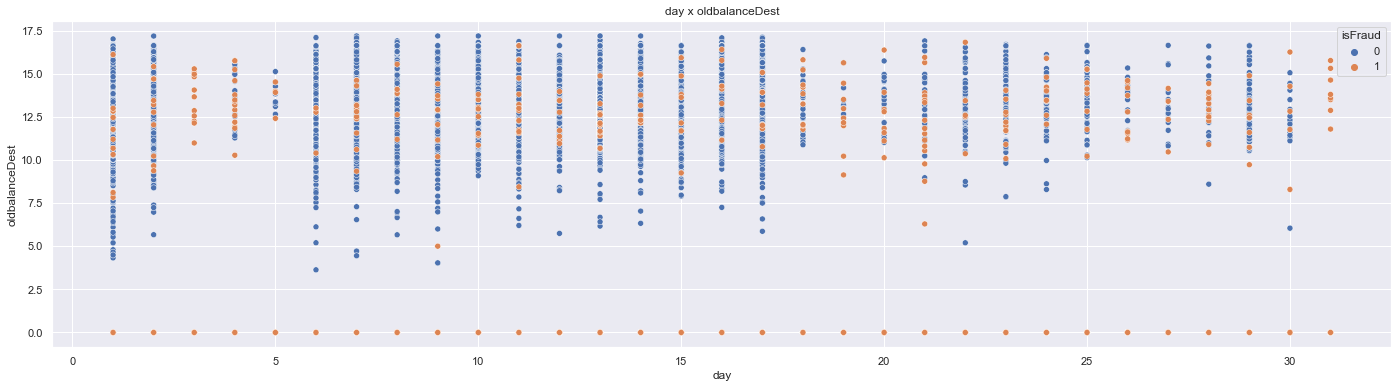

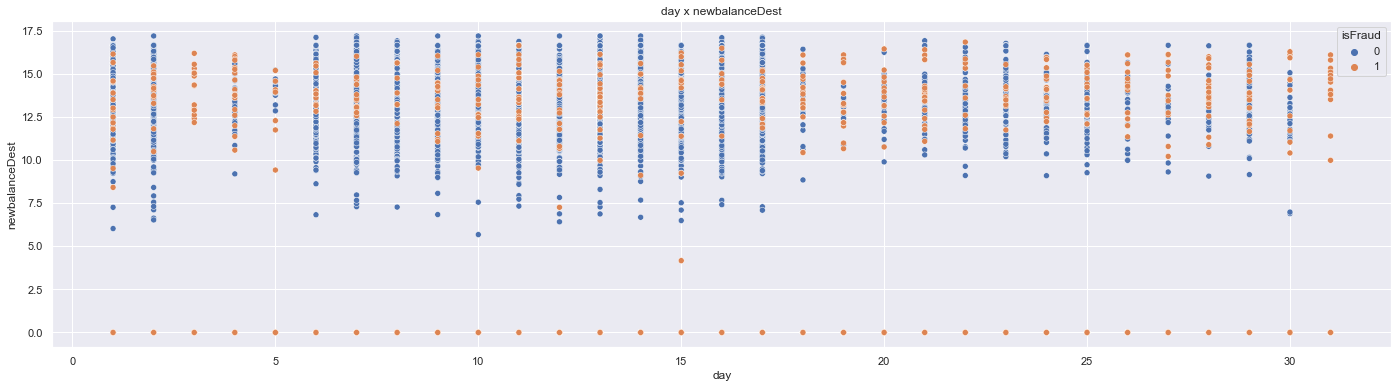

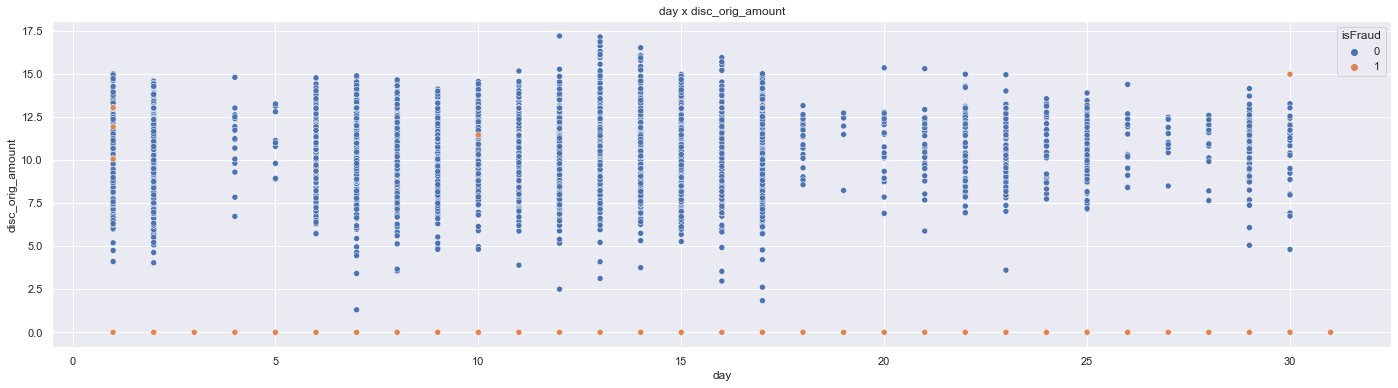

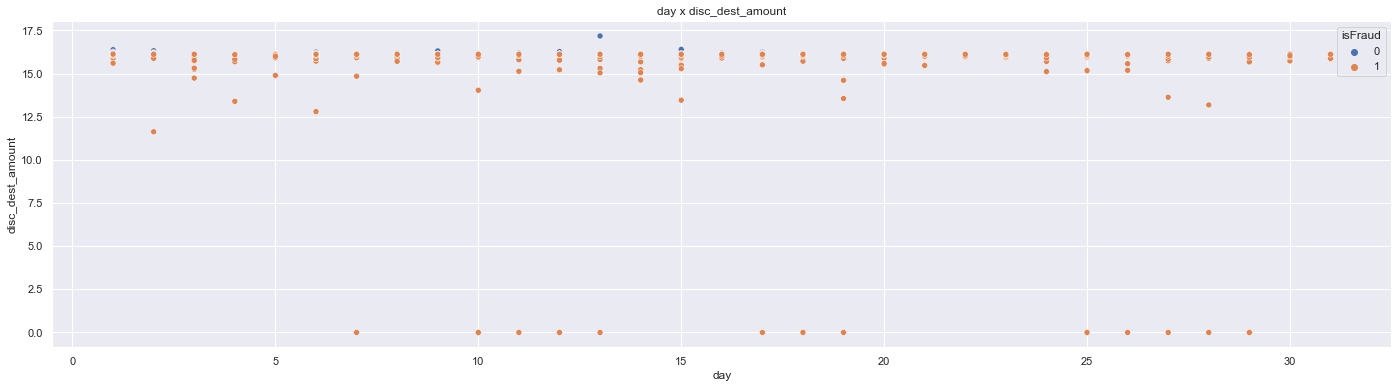

In [215]:
# aux=df4.copy()
# aux=pd.concat([aux,df1[['step','isFraud']]],axis=1)
for var in continuous:
    plt.figure(figsize=(24,6))
    sns.scatterplot(x='day', y=var, hue='isFraud', data=aux)
    plt.ylabel(var)
    plt.title('day x ' + var)
    plt.show()

-0.7455842640972611


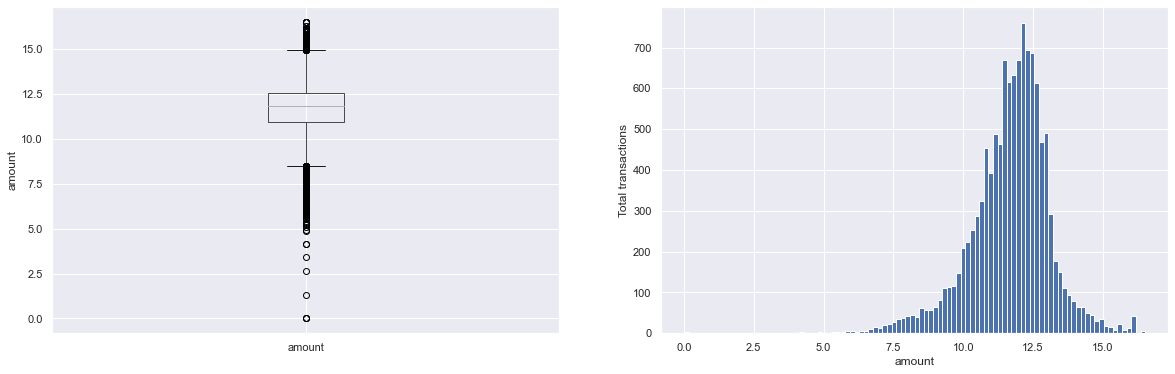

-0.8196419864970268


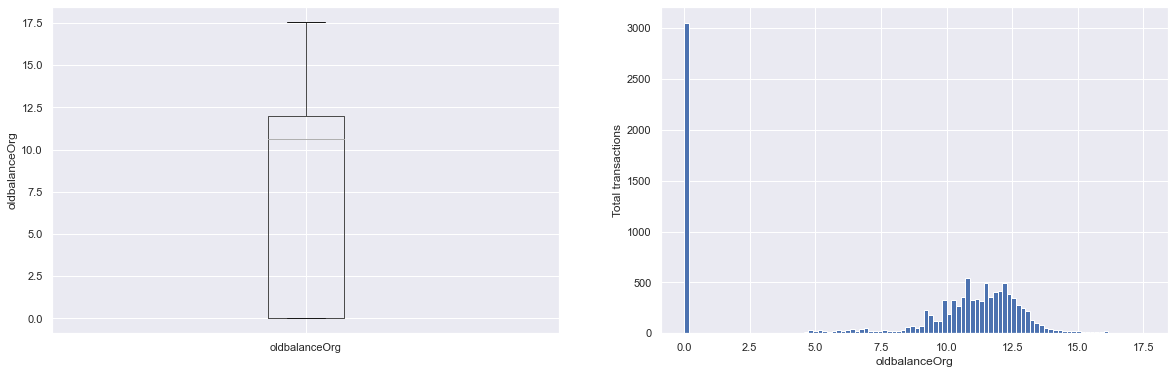

1.207780506817451


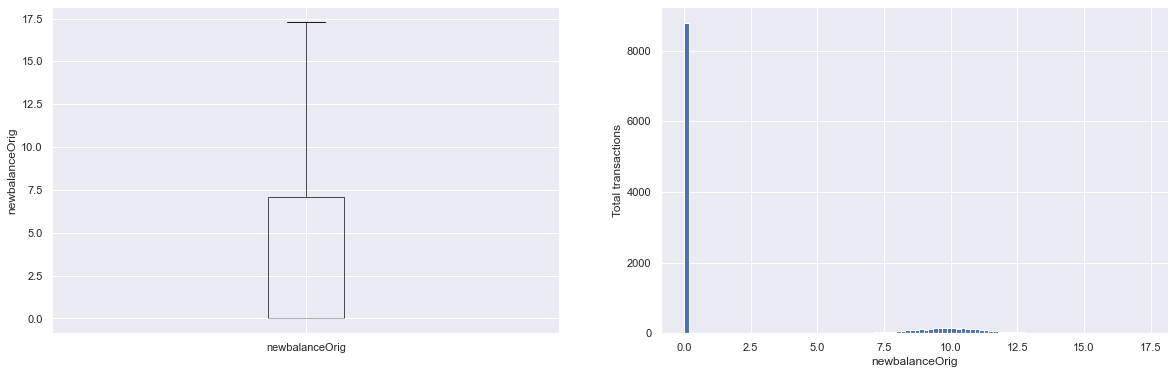

-1.2457399515271208


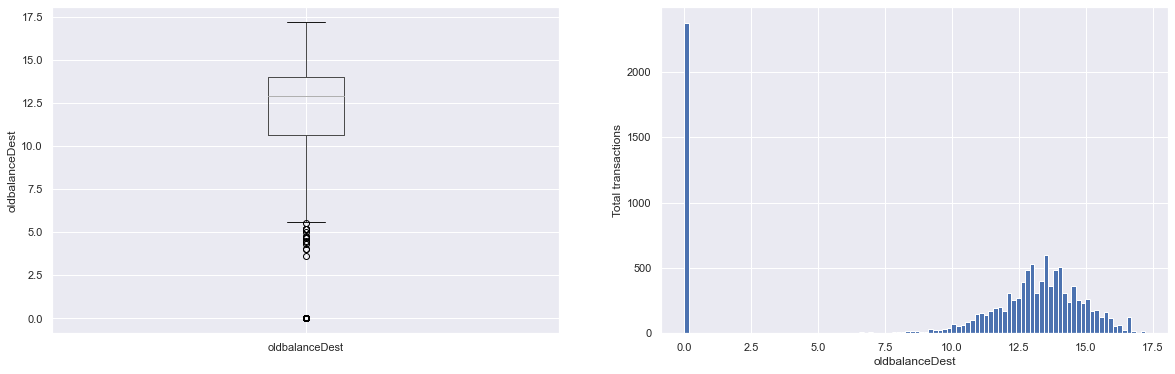

-2.9688203663202475


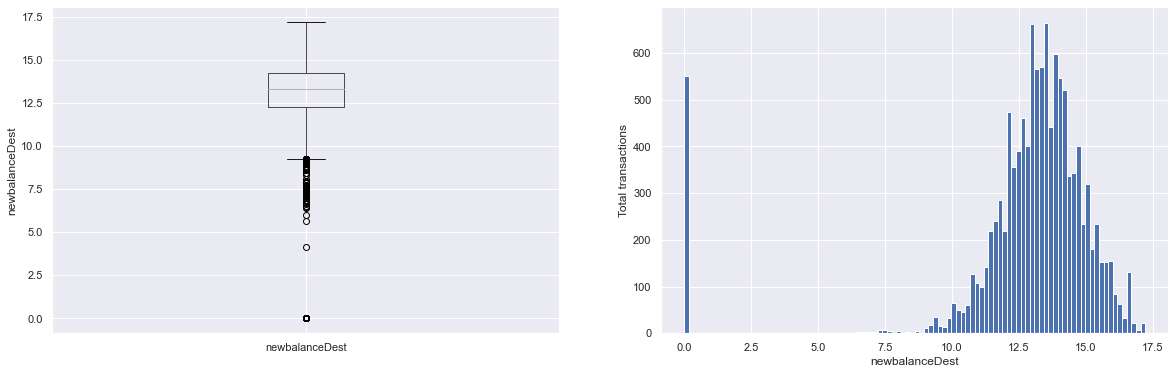

-0.501895124626563


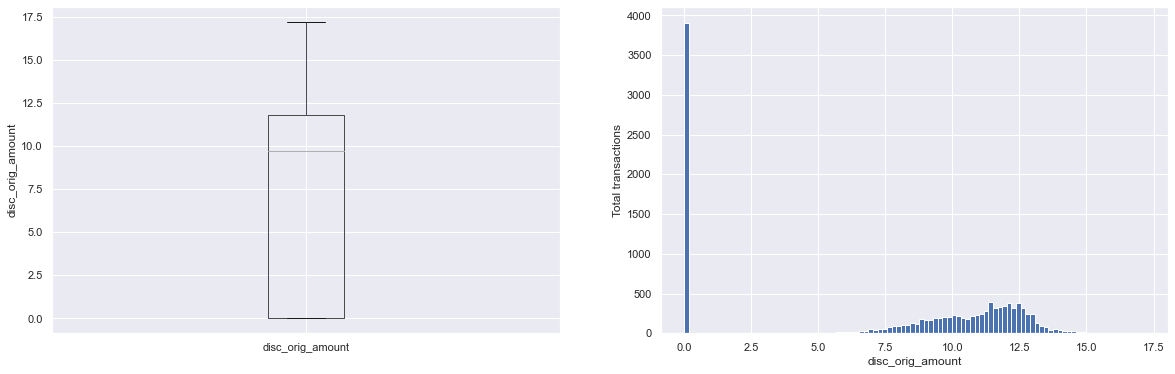

-26.350687805013752


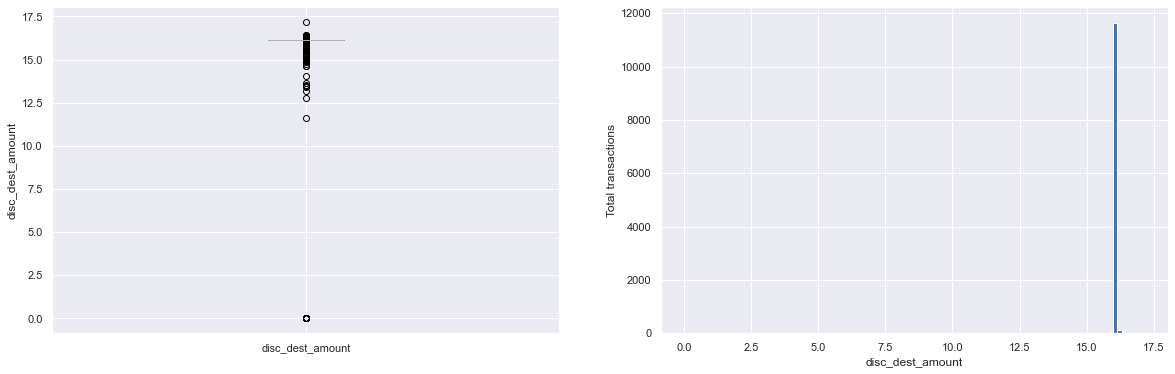

In [216]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution
# aux=df4.copy()
for var in continuous:
    print(aux[var].skew())
    plt.figure(figsize=(20,6))
    plt.subplot(1, 2, 1)
    fig = aux.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = aux[var].hist(bins=100)
    fig.set_ylabel('Total transactions')
    fig.set_xlabel(var)

    plt.show()

In [217]:
cont_data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,disc_orig_amount,disc_dest_amount
0,10.291774,10.379225,7.899506,14.558724,14.572651,0.009950,16.118096
1,12.123423,0.000000,0.000000,15.666518,15.695031,12.123423,16.118096
2,14.739973,0.000000,0.000000,16.204654,16.412604,14.739973,16.118096
3,12.897348,0.000000,0.000000,13.499577,13.936275,12.897348,16.118096
4,11.504686,0.000000,0.000000,13.144490,13.321813,11.504687,16.118096
...,...,...,...,...,...,...,...
11896,13.215268,13.215268,0.000000,11.846417,13.441923,0.009950,16.118096
11897,16.061915,16.061915,0.000000,0.000000,16.061915,0.009950,16.118096
11898,12.029380,12.029380,0.000000,14.655294,14.725168,0.009950,16.118096
11899,11.441260,11.441260,0.000000,14.718159,14.755209,0.009950,16.118096


In [218]:
cont_data.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,disc_orig_amount,disc_dest_amount
count,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000
mean,11.672361,8.259098,2.588087,10.596004,12.763749,7.323282,16.090946
std,1.451196,5.116440,4.432275,5.504812,3.154227,5.330531,0.597594
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.926902,0.000000,0.000000,10.648267,12.264327,0.009950,16.118096
50%,11.833489,10.643995,0.000000,12.904832,13.318804,9.695266,16.118096
75%,12.538956,11.968736,7.063801,14.015534,14.256272,11.781558,16.118096
max,16.523561,17.566018,17.298063,17.216708,17.216708,17.188346,17.180336


## Discrete variables

In [220]:
disc_data=df5[discrete].drop(['isFraud','flag_outlier'],axis=1)

In [221]:
disc_data.sample(10)

,type,amount_anomaly_orig,amount_anomaly_dest,FluxOrig,FluxDest,num_of_transactions_dest,num_of_transactions_orig,day,hour
2457,0,True,False,0.0,1.0,2,1,7,5
9411,1,False,True,-1.0,1.0,2,1,1,7
8240,0,True,True,-1.0,1.0,1,1,7,11
11490,1,False,True,-1.0,0.0,1,1,21,5
7249,0,True,False,-1.0,1.0,2,1,9,10
6885,0,False,False,-1.0,1.0,1,1,13,9
10287,0,False,False,-1.0,1.0,1,1,15,5
5054,0,False,False,-1.0,1.0,2,1,2,7
9125,0,False,False,-1.0,1.0,1,1,12,12
5839,1,False,False,-1.0,1.0,2,1,10,4


### Cyclic transformation of time

In [222]:
disc_data.day.unique()

array([16, 23, 15, 17,  2, 13, 20,  1, 10,  8,  7, 28, 11,  9, 14,  6, 12,
       25, 29, 26,  4, 22, 24, 30, 21, 18, 27, 19,  5,  3, 31],
      dtype=int64)

In [223]:
disc_data['day']-=1

In [224]:
def cyclic_transf(s):
    norm = 2*math.pi*s/s.max()
    cos = np.cos(norm)
    sin = np.sin(norm)
    return cos,sin

In [225]:
disc_data['day_cos'],disc_data['day_sin']=cyclic_transf(disc_data['day'])

In [226]:
disc_data.hour.unique()

array([ 5,  6,  4, 12, 11,  9, 13,  8,  3,  7, 14, 10, 23,  1, 15,  0,  2,
       18, 16, 17, 22, 21, 20, 19], dtype=int64)

In [227]:
disc_data['hour_cos'],disc_data['hour_sin']=cyclic_transf(disc_data['hour'])

In [228]:
disc_data.drop(['day','hour'],axis=1,inplace=True)

In [229]:
disc_data.sample(5)

,type,amount_anomaly_orig,amount_anomaly_dest,FluxOrig,FluxDest,num_of_transactions_dest,num_of_transactions_orig,day_cos,day_sin,hour_cos,hour_sin
11344,0,False,False,-1.0,1.0,2,1,0.978148,0.207912,-0.917211,-0.398401
8541,0,True,False,-1.0,1.0,2,1,-0.309017,0.951057,-0.917211,-0.398401
8311,1,False,False,-1.0,1.0,3,1,0.309017,0.951057,-0.576680,-0.816970
2627,1,True,False,-1.0,1.0,3,1,-0.309017,0.951057,-0.917211,0.398401
4648,0,True,False,-1.0,1.0,1,1,0.104528,0.994522,0.203456,0.979084


## rescale discrete and categorical variables

rescale discrete and categorical variables to range of continuous variables (20)

In [230]:
(cont_data.max() - cont_data.min())

amount              16.523561
oldbalanceOrg       17.566018
newbalanceOrig      17.298063
oldbalanceDest      17.216708
newbalanceDest      17.216708
disc_orig_amount    17.188346
disc_dest_amount    17.180336
dtype: float64

In [235]:
disc_data.dtypes

type                          int32
amount_anomaly_orig           int32
amount_anomaly_dest           int32
FluxOrig                    float64
FluxDest                    float64
num_of_transactions_dest      int64
num_of_transactions_orig      int64
day_cos                     float64
day_sin                     float64
hour_cos                    float64
hour_sin                    float64
dtype: object

In [234]:
disc_data[['type','amount_anomaly_orig','amount_anomaly_dest']]=disc_data[['type','amount_anomaly_orig','amount_anomaly_dest']].astype(int)

In [242]:
(disc_data.max() - disc_data.min())

type                         1.000000
amount_anomaly_orig          1.000000
amount_anomaly_dest          1.000000
FluxOrig                     1.000000
FluxDest                     2.000000
num_of_transactions_dest    10.000000
num_of_transactions_orig     1.000000
day_cos                      2.000000
day_sin                      1.989044
hour_cos                     1.990686
hour_sin                     1.995338
dtype: float64

In [243]:
disc_data_r=disc_data.copy()
disc_data_r[['FluxOrig','type','amount_anomaly_orig','amount_anomaly_dest','num_of_transactions_orig']]*=20
disc_data_r[['FluxDest','day_cos','day_sin','hour_cos','hour_sin']]*=10
disc_data_r[['num_of_transactions_dest']]*=2

In [244]:
(disc_data_r.max() - disc_data_r.min())

type                        20.000000
amount_anomaly_orig         20.000000
amount_anomaly_dest         20.000000
FluxOrig                    20.000000
FluxDest                    20.000000
num_of_transactions_dest    20.000000
num_of_transactions_orig    20.000000
day_cos                     20.000000
day_sin                     19.890438
hour_cos                    19.906859
hour_sin                    19.953375
dtype: float64

# MACHINE LEARNING

In [345]:
df6=pd.concat([cont_data,disc_data_r,df5['isFraud']],axis=1)

In [346]:
target=['isFraud']

In [347]:
df6.iloc[:,0:-1]=df6.iloc[:,0:-1]/20

In [348]:
(df6.max() - df6.min())

amount                      0.826178
oldbalanceOrg               0.878301
newbalanceOrig              0.864903
oldbalanceDest              0.860835
newbalanceDest              0.860835
disc_orig_amount            0.859417
disc_dest_amount            0.859017
type                        1.000000
amount_anomaly_orig         1.000000
amount_anomaly_dest         1.000000
FluxOrig                    1.000000
FluxDest                    1.000000
num_of_transactions_dest    1.000000
num_of_transactions_orig    1.000000
day_cos                     1.000000
day_sin                     0.994522
hour_cos                    0.995343
hour_sin                    0.997669
isFraud                     1.000000
dtype: float64

## Baseline
random choice

In [349]:
# Split dataset into training and test
X=df6.drop(['isFraud'],axis=1)
y=df6['isFraud']
x_train, x_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

In [350]:
frauds_weights=df6['isFraud'].value_counts( normalize=True ).sort_index().tolist()
k_num = y_test.shape[0]
yhat_random = random.choices( population=[0, 1],  
                              weights=frauds_weights,
                              k=k_num )

  Model Name  Accuracy  Balanced accuracy  F1 score  Kappa Metrics
0     random  0.861403           0.496422  0.067797      -0.007044 



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

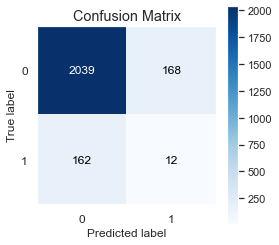

In [351]:
print( ml_error('random',y_test,yhat_random), '\n' )

# # Classification report
# print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(4,4))

## Testing ML algorithms

SVM is the winner

In [316]:
from sklearn.neighbors import KNeighborsClassifier

In [357]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN_cv = cross_validation( target, df6, 5, 'KNN-3', KNN, verbose=False )
KNN_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,KNN-3,0.998 +/- 0.001,0.985 +/- 0.005,0.984 +/- 0.006,0.983 +/- 0.007


In [358]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN_cv = cross_validation( target, df6, 5, 'KNN-5', KNN, verbose=False )
KNN_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,KNN-5,0.997 +/- 0.001,0.983 +/- 0.005,0.981 +/- 0.006,0.98 +/- 0.007


In [359]:
KNN = KNeighborsClassifier(n_neighbors=10)
KNN_cv = cross_validation( target, df6, 5, 'KNN-10', KNN, verbose=False )
KNN_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,KNN-10,0.996 +/- 0.001,0.969 +/- 0.006,0.967 +/- 0.007,0.964 +/- 0.007


In [330]:
from sklearn.linear_model import LogisticRegression

In [353]:
lg = LogisticRegression()
lg_cv = cross_validation( target, df6, 5, 'Logistic Regression', lg, verbose=False )
lg_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,Logistic Regression,0.999 +/- 0.001,0.99 +/- 0.004,0.99 +/- 0.004,0.989 +/- 0.005


In [360]:
from sklearn.tree import DecisionTreeClassifier

In [361]:
dtc = DecisionTreeClassifier()
dtc_cv = cross_validation( target, df6, 5, 'Decision Tree', dtc, verbose=False )
dtc_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,Decision Tree,0.999 +/- 0.001,0.996 +/- 0.003,0.992 +/- 0.006,0.991 +/- 0.006


In [362]:
from sklearn.ensemble import RandomForestClassifier

In [452]:
rfc = RandomForestClassifier()
rfc_cv = cross_validation( target, df6, 5, 'Random Forest', rfc, verbose=False )
rfc_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,Random Forest,0.999 +/- 0.0,0.996 +/- 0.004,0.996 +/- 0.004,0.996 +/- 0.004


In [448]:
import xgboost as xgb

In [451]:
xgbc = xgb.XGBClassifier(max_depth=10)
xgbc_cv = cross_validation( target, df6, 5, 'XGBoost', xgbc, verbose=False )
xgbc_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,XGBoost,0.999 +/- 0.0,0.996 +/- 0.004,0.996 +/- 0.004,0.996 +/- 0.004


In [442]:
from sklearn.svm import SVC

In [454]:
svm = SVC(kernel='linear')
svm_cv_l = cross_validation( target, df6, 5, 'SVM_linear', svm, verbose=False )
svm_cv_l

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,SVM_linear,1.0 +/- 0.0,0.997 +/- 0.003,0.997 +/- 0.003,0.997 +/- 0.003


In [455]:
svm = SVC()
svm_cv_rbf = cross_validation( target, df6, 5, 'SVM_rbf', svm, verbose=False )
svm_cv_rbf

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,SVM_rbf,1.0 +/- 0.0,0.997 +/- 0.003,0.997 +/- 0.003,0.997 +/- 0.003


In [440]:
model = ml.Sequential()
model.add( l.Dense( units=64, input_dim=df6.shape[1]-1, activation='relu' ) )
model.add( l.Dense( units=16, activation='relu') )
model.add( l.Dense( units=1, activation='sigmoid') )
model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )
NN_cv = cross_validation( target, df6, 5, 'Neural Net', model, verbose=1 )
NN_cv

jiii
Train on 9520 samples, validate on 2381 samples
Epoch 1/20
9520/9520 [==============================] - 1s 120us/sample - loss: 0.1320 - acc: 0.9558 - val_loss: 0.0371 - val_acc: 0.9878
Epoch 2/20
9520/9520 [==============================] - 1s 54us/sample - loss: 0.0190 - acc: 0.9966 - val_loss: 0.0169 - val_acc: 0.9979
Epoch 3/20
9520/9520 [==============================] - 0s 45us/sample - loss: 0.0099 - acc: 0.9985 - val_loss: 0.0122 - val_acc: 0.9987
Epoch 4/20
9520/9520 [==============================] - 0s 45us/sample - loss: 0.0063 - acc: 0.9994 - val_loss: 0.0100 - val_acc: 0.9992
Epoch 5/20
9520/9520 [==============================] - 0s 46us/sample - loss: 0.0051 - acc: 0.9995 - val_loss: 0.0089 - val_acc: 0.9992
Epoch 6/20
9520/9520 [==============================] - 0s 44us/sample - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0076 - val_acc: 0.9992
Epoch 7/20
9520/9520 [==============================] - 0s 47us/sample - loss: 0.0036 - acc: 0.9997 - val_loss: 0.0071 - val

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,Neural Net,0.999 +/- 0.001,0.997 +/- 0.003,0.996 +/- 0.004,0.995 +/- 0.004


In [456]:
modelling_result_cv = pd.concat( [
    KNN_cv,
    lg_cv,
    dtc_cv,
    rfc_cv,
    xgbc_cv,
    svm_cv_l,
    svm_cv_rbf,
    NN_cv] )
modelling_result_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,KNN-10,0.996 +/- 0.001,0.969 +/- 0.006,0.967 +/- 0.007,0.964 +/- 0.007
0,Logistic Regression,0.999 +/- 0.001,0.99 +/- 0.004,0.99 +/- 0.004,0.989 +/- 0.005
0,Decision Tree,0.999 +/- 0.001,0.996 +/- 0.003,0.992 +/- 0.006,0.991 +/- 0.006
0,Random Forest,0.999 +/- 0.0,0.996 +/- 0.004,0.996 +/- 0.004,0.996 +/- 0.004
0,XGBoost,0.999 +/- 0.0,0.996 +/- 0.004,0.996 +/- 0.004,0.996 +/- 0.004
0,SVM_linear,1.0 +/- 0.0,0.997 +/- 0.003,0.997 +/- 0.003,0.997 +/- 0.003
0,SVM_rbf,1.0 +/- 0.0,0.997 +/- 0.003,0.997 +/- 0.003,0.997 +/- 0.003
0,Neural Net,0.999 +/- 0.001,0.997 +/- 0.003,0.996 +/- 0.004,0.995 +/- 0.004


# BUSYNESS ANALYSIS

In [ ]:
df3=df2.copy()

### Prevendo tudo como fraude

In [ ]:
def lucro_consultoria(row):
    if row['FraudPred']==1 and row['isFraud']==1:
        lucro=0.25*row['amount']
    elif row['FraudPred']==1 and row['isFraud']==0:
        lucro=0.05*row['amount']
    elif row['FraudPred']==0 and row['isFraud']==1:
        lucro=-1.00*row['amount']
    else:
        lucro=0*row['amount']
    return lucro

In [ ]:
aux=df3.copy()
aux['FraudPred']=1

In [ ]:
lucro_tudo_fraude=aux.apply(lucro_consultoria,axis=1)

In [ ]:
lucro_tudo_fraude.sum()

In [ ]:
df3['amount'].sum()

In [ ]:
lucro_tudo_fraude.sum()/df3['amount'].sum()

### 100% de acurácia

In [ ]:
aux=df3.copy()
aux['FraudPred']=df3['isFraud']

In [ ]:
lucro_acuracia_perfeita=aux.apply(lucro_consultoria,axis=1)

In [ ]:
lucro_acuracia_perfeita.sum()

In [ ]:
lucro_acuracia_perfeita.sum()/df3['amount'].sum()

In [ ]:
lucro_tudo_fraude.sum()/lucro_acuracia_perfeita.sum()